In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from data_loading import *
from isoform_pairwise_metrics import *
from plotting import y1h_pdi_per_tf_gene_plot, m1h_activation_per_tf_gene_plot

In [34]:
#pd.read_csv('../../data/processed/190914_6K_affect_of_mapped_uniprot_dbds_with_flank_for_juan.tsv',
 #                sep='\t')

In [2]:
tfs = load_annotated_6k_collection()

In [3]:
# count
print(len(tfs), 'TF genes')
print(sum([len(tf.orfs[0].aa_seq_features) > 0 for tf in tfs.values()]),
      'TF genes with at least one Pfam domain in longest cloned isoform')
print(sum([len(tf.orfs[0].dna_binding_domains) > 0 for tf in tfs.values()]))
tfs_no_dbd = {k: v for k, v in tfs.items()
              if len(v.orfs[0].dna_binding_domains) == 0
              and len(v.orfs[0].aa_seq_features) > 0}

309 TF genes
295 TF genes with at least one Pfam domain in longest cloned isoform
267


In [74]:
# DEBUG


,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length,is_DBD,is_DBD_flank
0,ZBTB18,ZBTB18-1,ZBTB18-2,PF00651,0,0,0,108,False,False
1,ZBTB18,ZBTB18-1,ZBTB18-2,PF13894,9,0,0,21,True,False
2,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2_ZF_array_5,0,0,0,125,True,False
3,ZBTB18,ZBTB18-1,ZBTB18-2,PF13894_flank_C,0,0,0,15,False,True
4,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2_ZF_array_5_flank_N,0,0,0,15,False,True


In [4]:
df = pd.concat([g.aa_feature_disruption(g.orfs[0].name) for g in tfs.values()])
df['is_DBD'] = df['accession'].isin(load_dbd_accessions())
df['is_DBD_flank'] = (df['accession'].str.endswith('_flank_N') |
                      df['accession'].str.endswith('_flank_C'))

# should I remove insertions?
df = (df.loc[df['is_DBD'], :].groupby(['gene', 'ref_iso', 'alt_iso'])[['deletion', 'insertion', 'frameshift']].sum().sum(axis=1) / df.loc[df['is_DBD'], :].groupby(['gene', 'ref_iso', 'alt_iso'])['length'].sum()).to_frame(name='dbd_fraction').reset_index()

In [5]:
df.head()

,gene,ref_iso,alt_iso,dbd_fraction
0,AEBP2,AEBP2-2,AEBP2-3,0.000000
1,ARNT2,ARNT2-1,ARNT2-2,0.000000
2,ARNT2,ARNT2-1,ARNT2-3,0.000000
3,ARNTL,ARNTL-1,ARNTL-2,0.000000
4,ARNTL2,ARNTL2-1,ARNTL2-2,0.037037


In [2]:
#df = pd.read_csv('../../data/processed/190914_6K_affect_of_mapped_uniprot_dbds_with_flank_for_juan.tsv',
#                 sep='\t')
#dom_frac = df.groupby('isoacc')['num_match'].sum() / df.groupby('isoacc')['dom_len'].sum()
#dom_frac = dom_frac.to_frame(name='dbd_fraction')
#dom_frac['gene'] = dom_frac.index.map(df.drop_duplicates('isoacc').set_index('isoacc')['gene'])
#df = dom_frac

In [4]:
isoforms = load_valid_isoform_clones()
y1h = load_y1h_pdi_data()
y1h = y1h.drop_duplicates()
n_pdi = (y1h.drop(columns='tf')
            .set_index('unique_acc')
            .sum(axis=1))
n_pdi.index = n_pdi.index.map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
n_pdi.head()

unique_acc
CREB1-1    0
CREB1-2    3
DLX1-1     9
DLX1-2     0
DLX4-1     3
dtype: int64

In [7]:
# map each isoform to change in PDI vs reference
def delta_pdi(row):
    iso_acc = row['alt_iso']
    ref_acc = row['ref_iso']
    if iso_acc == ref_acc:
        return np.nan
    n_ref = n_pdi.get(ref_acc, np.nan)
    n_iso = n_pdi.get(iso_acc, np.nan)
    if n_ref == 0:
        return np.nan
    return (n_iso - n_ref) / n_ref


df['delta_pdi'] = df.apply(delta_pdi, axis=1)
df = df.dropna(subset=['delta_pdi'])

In [8]:
df['delta_pdi'].values

array([-1.        ,  2.33333333, -1.        , -1.        , -1.        ,
       -1.        , -1.        , -0.11764706, -0.66666667,  0.        ,
        0.        , -0.8       ,  0.        , -1.        , -1.        ,
        2.        , -1.        ,  0.        , -1.        , -1.        ,
       -1.        , -1.        ,  2.        ,  5.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        ,  0.5       ,  0.        ,  0.        , -1.        ,
        0.        , -1.        , -1.        , -1.        ,  0.11111111,
       -0.33333333, -0.66666667, -0.11111111, -0.11111111,  0.05555556,
       -1.        ,  0.8       ,  0.8       ,  1.4       ,  1.        ,
       -0.25      ,  0.30769231,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [9]:
df['dbd_pct_lost'] = df['dbd_fraction'] * 100.

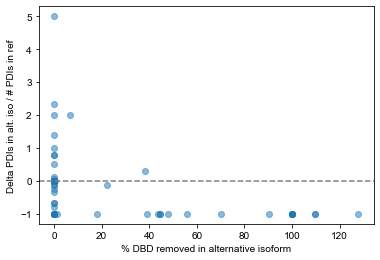

In [10]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['dbd_pct_lost'].values,
           df['delta_pdi'].values,
           alpha=0.5)
ax.axhline(0, linestyle='--', color='grey')
ax.set_ylabel('Delta PDIs in alt. iso / # PDIs in ref')
ax.set_xlabel('% DBD removed in alternative isoform')
plt.savefig('../../figures/DBD_change_vs_PDI_scatter.pdf', 
            bbox_inches='tight')

In [11]:
df.sort_values('delta_pdi', ascending=False).head()

,gene,ref_iso,alt_iso,dbd_fraction,delta_pdi,dbd_pct_lost
115,LHX9,LHX9-1,LHX9-3,0.000000,5.000000,0.000000
21,DLX4,DLX4-1,DLX4-2,0.000000,2.333333,0.000000
85,HEY1,HEY1-1,HEY1-2,0.066667,2.000000,6.666667
114,LHX9,LHX9-1,LHX9-2,0.000000,2.000000,0.000000
253,TFAP2A,TFAP2A-1,TFAP2A-4,0.000000,1.400000,0.000000


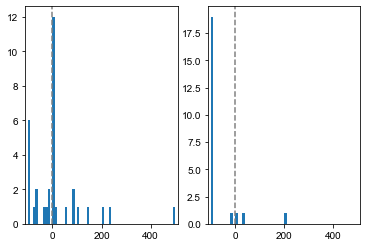

In [12]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(df.loc[df['dbd_pct_lost'] == 0, 'delta_pdi'].values * 100,
             range=(-100, 500), bins=6*10)
axes[1].hist(df.loc[df['dbd_pct_lost'] > 0, 'delta_pdi'].values * 100,
             range=(-100, 500), bins=6*10)
for ax in axes:
    ax.axvline(0, linestyle='--', color='grey')
    ax.set_xlim(-110, 510)

In [13]:
df['dbd_affected'] = df['dbd_pct_lost'] > 0
df['dbd_affected'] = df['dbd_affected'].map({False: 'Full DBD in\nalternative isoform', True: 'Partial or full\nloss of DBD'})

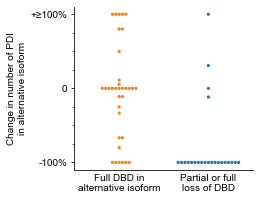

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.2, 3)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)
sns.swarmplot(data=df, 
              y='delta_pdi_trunc', 
              x='dbd_affected',
              size=3.2,
              ax=ax,
              alpha=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('')
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.invert_xaxis()
ax.set_ylabel('Change in number of PDI\nin alternative isoform')
plt.savefig('../../figures/DBD_change_vs_PDI_truncated_inverted.pdf', bbox_inches='tight')

In [64]:
(df['dbd_pct_lost'] > 0).sum()

23

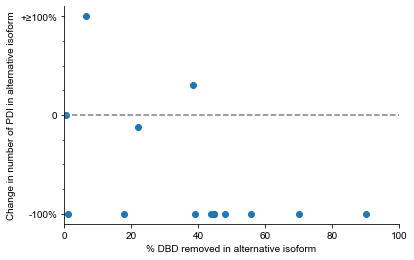

In [15]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
           df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1)
ax.axhline(0, linestyle='--', color='grey')

ax.set_xlabel('% DBD removed in alternative isoform')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 100)
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.set_ylabel('Change in number of PDI in alternative isoform')
plt.savefig('../../figures/DBD_change_vs_PDI_scatter_only_partially_affected.pdf', 
            bbox_inches='tight')

In [16]:
df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100) & (df['delta_pdi_trunc'] > -1), :]

,gene,ref_iso,alt_iso,dbd_fraction,delta_pdi,dbd_pct_lost,dbd_affected,delta_pdi_trunc
36,EBF3,EBF3-1,EBF3-3,0.221333,-0.117647,22.133333,Partial or full\nloss of DBD,-0.117647
85,HEY1,HEY1-1,HEY1-2,0.066667,2.000000,6.666667,Partial or full\nloss of DBD,1.000000
294,ZIC3,ZIC3-1,ZIC3-2,0.384615,0.307692,38.461538,Partial or full\nloss of DBD,0.307692
295,ZIC3,ZIC3-1,ZIC3-3,0.006410,0.000000,0.641026,Partial or full\nloss of DBD,0.000000


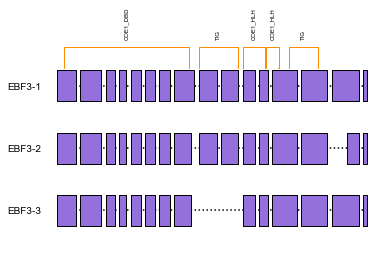

In [17]:
tfs['EBF3'].exon_diagram()

In [5]:
m1h = load_m1h_activation_data()

In [6]:
y1h.head()

,tf,unique_acc,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,HS1185,...,MUT_281,MUT_30,MUT_32,MUT_36,MUT_37,MUT_40,MUT_41,MUT_46,MUT_64,MUT_75
162,CREB1,CREB1|1/2|02E01,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,CREB1,CREB1|2/2|01F12,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,DLX1,DLX1|1/2|07A12,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
174,DLX1,DLX1|2/2|07E09,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,DLX4,DLX4|1/3|11A04,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
m1h.head()

,gene,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3
360,AEBP2,AEBP2|2/3|05F03,0.241019,0.189211,0.473661
359,AEBP2,AEBP2|3/3|05E07,-0.276303,-0.305477,-0.121186
0,ARNT2,ARNT2|1/6|08C12,4.498733,4.501519,4.297244
1,ARNT2,ARNT2|2/6|09E01,2.407721,2.407411,2.197963
3,ARNTL2,ARNTL2|2/5|12C06,0.398027,0.391809,0.299461


In [10]:
# TODO: move to per TF gene notebook
for gene_name, tf in tfs.items():
    if gene_name in y1h['tf'].values:
        y1h_pdi_per_tf_gene_plot(gene_name, y1h)
        plt.savefig('../../figures/per_gene/y1h_profile/{}_y1h_profile.pdf'.format(gene_name),
                    bbox_inches='tight')
        plt.close(plt.gcf())
    if gene_name in m1h['gene'].values:
        m1h_activation_per_tf_gene_plot(gene_name, m1h)
        plt.savefig('../../figures/per_gene/m1h_profile/{}_m1h_profile.pdf'.format(gene_name),
                   bbox_inches='tight')
        plt.close(plt.gcf())
    tf.exon_diagram()
    plt.savefig('../../figures/per_gene/exon_diagram/{}_exon_diagram.pdf'.format(gene_name),
                bbox_inches='tight')
    plt.close(plt.gcf())

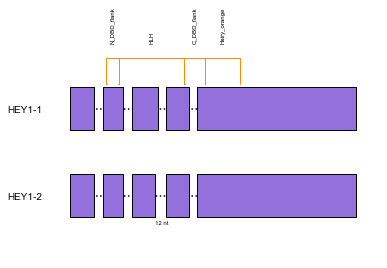

In [71]:
tfs['HEY1'].exon_diagram()

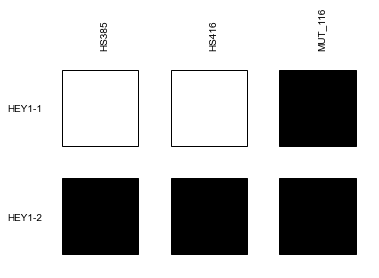

In [78]:
y1h_pdi_per_tf_gene_plot('HEY1', y1h)

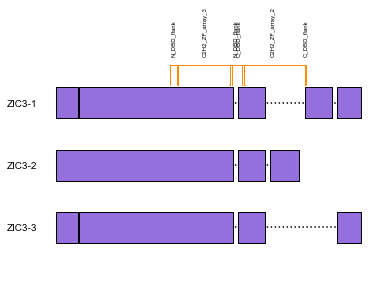

In [72]:
tfs['ZIC3'].exon_diagram()

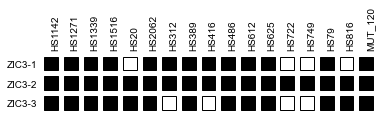

In [77]:
y1h_pdi_per_tf_gene_plot('ZIC3', y1h)

In [24]:
tfs['EBF3'].orfs[0].dna_binding_domains

[Pfam_domain: PF16422 COE1_DBD 17-247,
 Pfam_domain: PF01833 TIG 263-345,
 Pfam_domain: PF01833 TIG 438-498]

In [27]:
df.loc[df['dbd_affected'].str.startswith('Full'), :].sort_values('delta_pdi')

,gene,ref_iso,alt_iso,dbd_fraction,delta_pdi,dbd_pct_lost,dbd_affected,delta_pdi_trunc
74,GATA3,GATA3-1,GATA3-2,0.0,-1.000000,0.0,Full DBD in\nalternative isoform,-1.000000
118,MAX,MAX-1,MAX-4,0.0,-1.000000,0.0,Full DBD in\nalternative isoform,-1.000000
125,MEOX1,MEOX1-1,MEOX1-2,0.0,-1.000000,0.0,Full DBD in\nalternative isoform,-1.000000
129,MLX,MLX-1,MLX-3,0.0,-1.000000,0.0,Full DBD in\nalternative isoform,-1.000000
183,PPARG,PPARG-1,PPARG-4,0.0,-1.000000,0.0,Full DBD in\nalternative isoform,-1.000000
182,PPARG,PPARG-1,PPARG-3,0.0,-1.000000,0.0,Full DBD in\nalternative isoform,-1.000000
71,FOXP3,FOXP3-1,FOXP3-5,0.0,-0.800000,0.0,Full DBD in\nalternative isoform,-0.800000
55,FLI1,FLI1-1,FLI1-2,0.0,-0.666667,0.0,Full DBD in\nalternative isoform,-0.666667
232,TBX5,TBX5-1,TBX5-3,0.0,-0.666667,0.0,Full DBD in\nalternative isoform,-0.666667
231,TBX5,TBX5-1,TBX5-2,0.0,-0.333333,0.0,Full DBD in\nalternative isoform,-0.333333


In [32]:
tfs['PPARG'].genomic_alignment_of_aa_seqs()

{'PPARG-1': 'MGETLGDSPIDPESDSFTDTLSANISQEMTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQSAIKVEPASPPYYSEKTQLYNKPHEEPSNSLMAIECRVCGDKASGFHYGVHACEGCKGFFRRTIRLKLIYDRCDLNCRIHKKSRNKCQYCRFQKCLAVGMSHNAIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDMNSLMMGEDKIKFKHITPLQEQSKEVAIRIFQGCQFRSVEAVQEITEYAKSIPGFVNLDLNDQVTLLKYGVHEIIYTMLASLMNKDGVLISEGQGFMTREFLKSLRKPFGDFMEPKFEFAVKFNALELDDSDLAIFIAVIILSGD-R-P-G-L-LNVKPIEDIQDNLLQALELQLKLNHPESSQLFAKLLQKMTDLRQIVTEHVQLLQVIKKTETDMSLHPLLQEIYKDLY',
 'PPARG-2': '----------------------------MTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQSAIKVEPASPPYYSEKTQLYNKPHEEPSNSLMAIECRVCGDKASGFHYGVHACEGCKGFFRRTIRLKLIYDRCDLNCRIHKKSRNKCQYCRFQKCLAVGMSHNAIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDMNSLMMGEDKIKFKHITPLQEQSKEVAIRIFQGCQFRSVEAVQEITEYAKSIPGFVNLDLNDQVTLLKYGVHEIIYTMLASLMNKDGVLISEGQGFMTREFLKSLRKPFGDFMEPKFEFAVKFNALELDDSDLAIFIAVIILSGD-R-P-G-L-LNVKPIEDIQDNLLQALELQLKLNHPES